In [739]:
import torch
import math
import numpy as np
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

In [757]:
X, c = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=.5)

In [758]:
x, z = X[:, 0], X[:, 1]

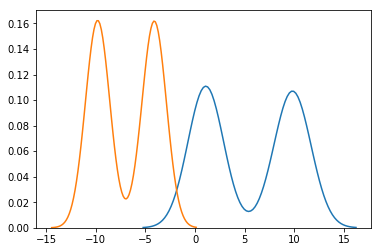

In [759]:
sns.kdeplot(x)
sns.kdeplot(z)

In [760]:
y = np.random.normal(0.5, .2, size=100)
y

array([ 0.49049253,  0.44681034,  0.10748374,  0.54595537,  0.62120584,
        0.45115323,  0.73797488,  0.24772783,  0.63173829,  0.24264774,
        0.55945838,  0.57677892,  0.13990301,  0.5576777 ,  0.49199572,
        0.78795678,  0.53326684,  0.42931619,  0.28443688,  0.40626827,
        0.32595277,  0.72832614,  0.34718408,  0.67417617,  0.51813148,
        0.5630967 ,  0.83920707,  0.2889784 ,  0.27921877,  0.59037771,
        0.5342262 ,  0.82157804,  0.33775381,  0.65079003,  0.48079544,
        0.80668211,  0.9300935 ,  0.38742214,  0.30633461,  0.34027429,
        0.42988061,  0.37274133,  0.36743787,  0.66139516,  0.67146655,
        0.53362195,  0.80347574,  0.64690813,  0.48353257,  0.52917624,
        0.3999961 ,  0.70530923,  0.36249106,  0.5590945 ,  0.21241697,
        0.52151124,  0.42493704,  0.62928579,  0.43088871,  0.84201181,
        0.08167929,  0.33914685,  0.19347491,  0.50534633,  0.65460215,
        0.49407613,  0.54345749,  0.49683573,  0.87828328,  0.06

In [850]:
x1 = torch.from_numpy(x).type(torch.float64)
z1 = torch.from_numpy(z).type(torch.float64)
y1 = torch.from_numpy(y).type(torch.float64)

In [851]:
def F(x, sigm, mu):
    return 1/(math.sqrt(2 * math.pi) * sigm) * torch.exp(-1/(2*sigm**2) * (x - mu) ** 2)

In [852]:
pnorm = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([2.]))

log_p = torch.log(torch.tensor([0.2]).type(torch.float64))

mu1x = torch.randn(1).type(torch.float64)
mu1z = torch.randn(1).type(torch.float64)
mu2x = torch.randn(1).type(torch.float64)
mu2z = torch.randn(1).type(torch.float64)

sigm1x = pnorm.sample().type(torch.float64)
sigm2x = pnorm.sample().type(torch.float64)
sigm1z = pnorm.sample().type(torch.float64)
sigm2z = pnorm.sample().type(torch.float64)

log_p.requires_grad = True
mu1x.requires_grad = True
mu1z.requires_grad = True
mu2x.requires_grad = True
mu2z.requires_grad = True
sigm1x.requires_grad = True
sigm2x.requires_grad = True
sigm1z.requires_grad = True
sigm2z.requires_grad = True

def likelihood(y):
    L = (y*log_p + (1 - y)*torch.log(1 - torch.exp(log_p)))
    #print(L)
    
    lx1 = y * (-torch.log(sigm1x) - 1/(2 * sigm1x ** 2) * (x1 - mu1x) ** 2)
    lx2 = (1-y) * (-torch.log(sigm2x) - 1/(2 * sigm2x ** 2) * (x1 - mu2x) ** 2)
    
    lz1 = y * (-torch.log(sigm1z) - 1/(2 * sigm1z ** 2) * (z1 - mu1z) ** 2)
    lz2 = (1-y) * (-torch.log(sigm2z) - 1/(2 * sigm2z ** 2) * (z1 - mu2z) ** 2)
    
    return -torch.mean(L + lx1 + lx2 + lz1 + lz2)

In [853]:
for i in range(20):
    gamma = 0.05
    for i in range(1000):
        L = likelihood(y1)
        L.backward()

        #gamma -= i / 50000
        with torch.no_grad():
            #print(log_p.grad)
            log_p = log_p - gamma * log_p.grad
            mu1x = mu1x - gamma * mu1x.grad
            mu1z = mu1z - gamma * mu1z.grad
            mu2x = mu2x - gamma * mu2x.grad
            mu2z = mu2z - gamma * mu2z.grad
            sigm1x = sigm1x - gamma * sigm1x.grad
            sigm2x = sigm2x - gamma * sigm2x.grad
            sigm1z = sigm1z - gamma * sigm1z.grad
            sigm2z = sigm2z - gamma * sigm2z.grad

        #log_p = torch.log(torch.exp(log_p) / torch.sum(torch.exp(log_p)))

        log_p.requires_grad = True
        mu1x.requires_grad = True
        mu1z.requires_grad = True
        mu2x.requires_grad = True
        mu2z.requires_grad = True
        sigm1x.requires_grad = True
        sigm2x.requires_grad = True
        sigm1z.requires_grad = True
        sigm2z.requires_grad = True

        log_p.grad = None
        mu1x.grad = None
        mu1z.grad = None
        mu2x.grad = None
        mu2z.grad = None
        sigm1x.grad = None
        sigm2x.grad = None
        sigm1z.grad = None
        sigm2z.grad = None

    print(torch.exp(log_p))
    #print((mu1x, mu2x), (mu1z, mu2z))
    #print((sigm1x, sigm1z), (sigm2x, sigm2z))
    
    with torch.no_grad():
        a = F(x1, sigm2x, mu2x) * F(z1, sigm2z, mu2z) * torch.exp(log_p)
        b = F(x1, sigm1x, mu1x) * F(z1, sigm1z, mu1z) * (1-torch.exp(log_p))

        y1 = a / (a + b)

    print(y1)

tensor([0.5029], dtype=torch.float64, grad_fn=<ExpBackward>)
tensor([0.4255, 0.4370, 0.4574, 0.4357, 0.4568, 0.4392, 0.4568, 0.4260, 0.4198,
        0.4195, 0.4465, 0.4226, 0.4509, 0.4332, 0.4815, 0.4537, 0.4312, 0.4495,
        0.4337, 0.4785, 0.4203, 0.4305, 0.4643, 0.4399, 0.4181, 0.4761, 0.4120,
        0.4524, 0.4296, 0.4157, 0.4761, 0.4649, 0.4134, 0.4196, 0.4641, 0.4300,
        0.4663, 0.4290, 0.4519, 0.4589, 0.4300, 0.4379, 0.4155, 0.4678, 0.4380,
        0.4556, 0.4625, 0.4771, 0.4140, 0.4646, 0.4208, 0.4144, 0.4256, 0.4553,
        0.4463, 0.4212, 0.4386, 0.4365, 0.4436, 0.4149, 0.4214, 0.4568, 0.4638,
        0.4613, 0.4760, 0.4506, 0.4642, 0.4182, 0.4190, 0.4609, 0.4470, 0.4319,
        0.4714, 0.4303, 0.4279, 0.4302, 0.4370, 0.4377, 0.4742, 0.4578, 0.4267,
        0.4721, 0.4284, 0.4585, 0.4222, 0.4694, 0.4664, 0.4496, 0.4475, 0.4352,
        0.4286, 0.4811, 0.4282, 0.4631, 0.4207, 0.4185, 0.4426, 0.4420, 0.4536,
        0.4583], dtype=torch.float64)
tensor([0.4432], dtyp

In [862]:
sigm1x = sigm1x.detach().numpy()[0]
sigm2x = sigm2x.detach().numpy()[0]
sigm1z = sigm1z.detach().numpy()[0]
sigm2z = sigm2z.detach().numpy()[0]

mu1x = mu1x.detach().numpy()[0]
mu2x = mu2x.detach().numpy()[0]
mu1z = mu1z.detach().numpy()[0]
mu2z = mu2z.detach().numpy()[0]

In [863]:
G1 = np.random.multivariate_normal([mu1x, mu2x], np.array([
    [sigm1x, 0],
    [0, sigm2x]
]), size=10000)

G2 = np.random.multivariate_normal([mu1z, mu2z], np.array([
    [sigm1z, 0],
    [0, sigm2z]
]), size=10000)

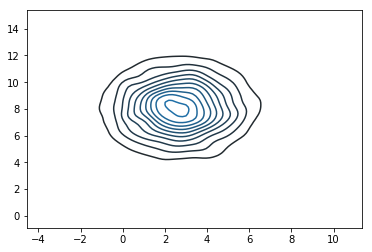

In [864]:
sns.kdeplot(G1[:, 0], G1[:, 1], kernel='gau')

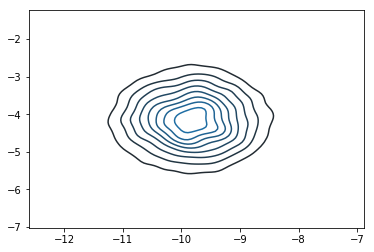

In [865]:
sns.kdeplot(G2[:, 0], G2[:, 1], kernel='gau')

In [867]:
pred = (y1 > .5).detach().numpy()

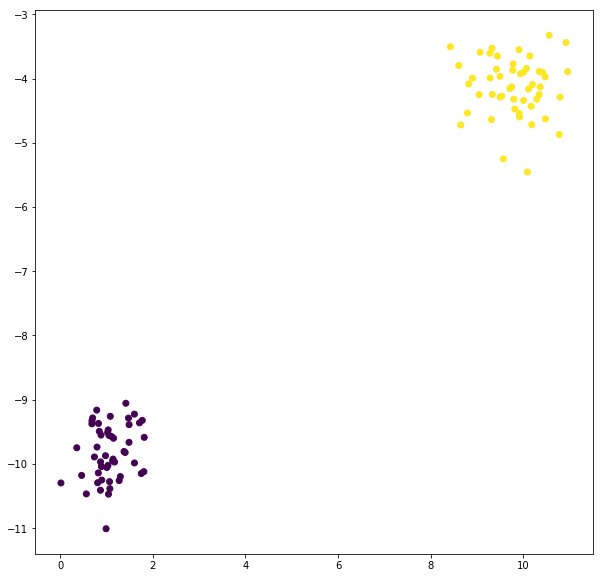

In [868]:
plt.figure(figsize=(10, 10))
plt.scatter(x=x, y=z, c=pred)